In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np

In [2]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

trainset = datasets.FashionMNIST('data_original/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data_original/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [3]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

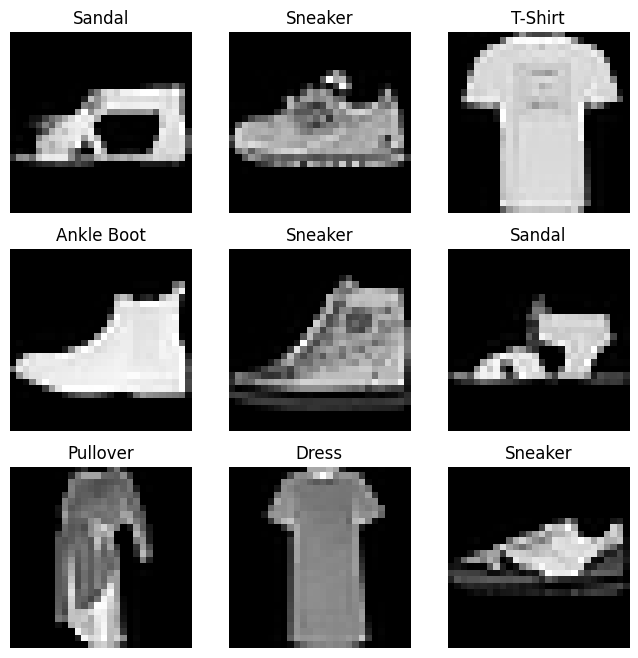

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        # print(f"{x.shape=}")
        
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        
        # print(f"{h=}")
        # print(f"{w=}")
        # print(f"{offset.shape=}")
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding)
        
        # print(f"{x.shape=}")
        return x

In [7]:
x, label = trainset[0]

In [8]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 deformable=False):

        super(MNISTClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)   
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [9]:
earlystopper_deform = EarlyStopper(min_delta = 0, patience =3)

model_deform = MNISTClassifier(deformable=True)

model_deform.to(device)

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv5): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [10]:
batch1 = next(iter(trainloader))
X, y = batch1
model_deform(X)

tensor([[-0.0151,  0.1292,  0.0391,  0.1678, -0.1540,  0.1298,  0.0069,  0.1562,
         -0.1028, -0.1267],
        [-0.0152,  0.1290,  0.0391,  0.1678, -0.1541,  0.1299,  0.0070,  0.1562,
         -0.1030, -0.1268],
        [-0.0155,  0.1297,  0.0382,  0.1662, -0.1529,  0.1303,  0.0064,  0.1558,
         -0.1032, -0.1243],
        [-0.0153,  0.1297,  0.0381,  0.1663, -0.1527,  0.1301,  0.0062,  0.1560,
         -0.1030, -0.1245],
        [-0.0151,  0.1291,  0.0386,  0.1673, -0.1540,  0.1301,  0.0073,  0.1565,
         -0.1032, -0.1262],
        [-0.0152,  0.1299,  0.0386,  0.1669, -0.1537,  0.1297,  0.0066,  0.1558,
         -0.1027, -0.1251],
        [-0.0152,  0.1301,  0.0390,  0.1676, -0.1549,  0.1299,  0.0071,  0.1556,
         -0.1023, -0.1265],
        [-0.0152,  0.1299,  0.0373,  0.1660, -0.1529,  0.1305,  0.0065,  0.1563,
         -0.1030, -0.1238],
        [-0.0156,  0.1299,  0.0376,  0.1658, -0.1526,  0.1306,  0.0065,  0.1559,
         -0.1034, -0.1234],
        [-0.0147,  

In [ ]:
deform_batch_tr_loss = {}
deform_batch_te_loss = {}

deform_best_test_loss = float('inf')

loss_fn_deform = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deform.parameters(), lr=0.001)

# epoch loss and accuracy
tr_loss_deform, tr_acc_deform = [], []
te_loss_deform, te_acc_deform = [], []

for t in (range(NUM_OF_EPOCHS)):
    model_deform.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = model_deform(X)
        loss = loss_fn_deform(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss_deform.append(sum(batch_loss)/batches)
    tr_acc_deform.append(sum(batch_accuracy)/batches)

    model_deform.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = model_deform(X)
            loss = loss_fn_deform(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss_deform.append(sum(batch_loss)/batches)
        te_acc_deform.append(sum(batch_accuracy)/batches)

    # Save the model_deform's weights after each epoch
    torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_model_deform_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss_deform[-1] < deform_best_test_loss:
        deform_best_test_loss = te_loss_deform[-1]
        # Save the model_deform's weights with the best test loss
        torch.save(model_deform.state_dict(), f"model_deform_weights/{BATCH_SIZE}_best_model_deform_weights.pth")

    if earlystopper_deform.early_stop(te_loss_deform[-1]):
      print(f"Early Stop at {t+1} epochs.")
      print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")
      break

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc_deform[-1]):>0.2f}%, Train_loss: {tr_loss_deform[-1]:>8f}, Test_accuracy: {(100*te_acc_deform[-1]):>0.2f}%, Test_loss: {te_loss_deform[-1]:>8f}")


Epoch 1 Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [04:52<00:00,  6.41it/s]


Epoch 1 Testing...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.69it/s]


Epoch 1: Train_accuracy: 72.73%, Train_loss: 0.720335, Test_accuracy: 79.04%, Test_loss: 0.546159
Epoch 2 Training...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [04:50<00:00,  6.45it/s]


Epoch 2 Testing...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.48it/s]


Epoch 2: Train_accuracy: 82.46%, Train_loss: 0.477314, Test_accuracy: 82.05%, Test_loss: 0.474849
Epoch 3 Training...


 32%|██████████████████████████████████████████████████████████                                                                                                                           | 601/1875 [01:34<03:22,  6.30it/s]